In [12]:
import matplotlib.pyplot as plt
from __future__ import print_function
import torch  # import the torch library
import torch.nn as nn # use the nn module (class)
import torch.nn.functional as F    # use the nn module as function
import torch.optim as optim # optimization (i.e., SGD, ada,)
import torchvision # load the dataset
import torchvision.transforms as transforms # adjust the input image
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from tqdm import tqdm
import datetime
import time # check the processing overhead
from torch.utils.data import random_split, DataLoader
import os
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from torch.utils.data import Subset

In [13]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        self.c1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size= 11, stride = 1, padding = 5)
        self.c2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size= 7, stride = 1, padding = 3)
        self.c3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size= 5, stride = 1, padding = 2)
        self.c4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size= 5, stride = 1, padding = 0)
        self.c5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size= 5, stride = 1, padding = 0)
        self.c6 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size= 5, stride = 1, padding = 0)

        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.F6 = nn.Linear(256, 512)
        self.F7 = nn.Linear(512, 10)

        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(0.5)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.MyRelu = nn.ReLU()


    def forward(self, x):
        # Conv Block 1
        x = self.bn1(self.c1(x))
        x = self.MyRelu(x)

        # Conv Block 2
        x = self.bn2(self.c2(x))
        x = self.MyRelu(x)

        # Conv Block 3
        x = self.bn3(self.c3(x))
        x = self.MyRelu(x)

        # Conv Block 4 (no BN)
        x = self.c4(x)
        x = self.MyRelu(x)

        # MaxPool + BN
        x = self.mp1(x)
        x = self.bn4(x)

        # Conv Block 5 (no BN)
        x = self.c5(x)
        x = self.MyRelu(x)

        # MaxPool + BN
        x = self.mp2(x)
        x = self.bn5(x)

        # Final Conv Block
        x = self.c6(x)
        x = self.MyRelu(x)

        # Global Average Pooling
        x = self.global_pool(x)

        # Flatten
        x = torch.flatten(x, 1)

        # Dropout + FC
        x = self.dropout(x)
        x = self.MyRelu(self.F6(x))
        x = self.F7(x)

        return x  # Raw logits

In [14]:
def data_download_and_preprocess(batch_size, validation_size):

    # Preparing for Data
    print('==> Preparing data..')

    # Training Data augmentation
    transform_train = transforms.Compose([
        transforms.AutoAugment(policy=AutoAugmentPolicy.CIFAR10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # Testing Data preparation
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # 1. Define full trainset twice (once for transform_train, once for transform_val)
    base_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
    targets = np.array(base_trainset.targets)

    # Stratified Split (80% train, 20% val)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=validation_size, random_state=42)
    train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))

    # Apply transforms separately
    train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train)
    val_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_test)

    train_subset = Subset(train_data, train_idx)
    val_subset = Subset(val_data, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    #Test set (same as before)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

    return train_loader, val_loader, test_loader


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    running_loss = 0.0

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}")
    for batch_idx, (data, target) in progress_bar:
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = loss_fn(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    print(f"Train Epoch: {epoch} \tLoss: {avg_loss:.6f}")

    accuracy = 100. * (output.argmax(dim=1) == target).sum().item() / len(target)

    return avg_loss, accuracy

def validate(model, device, data_loader, test=False):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    loss /= len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)

    test_or_val = "Test" if test else "Validation"

    print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_or_val, loss, correct, len(data_loader.dataset), accuracy))

    return loss, accuracy

def show_loss_fig(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid(True)

    dir = "figures"
    if not os.path.exists(dir):
        os.makedirs(dir)

    plt.savefig('loss_fig.png')
    plt.show()

def show_accuracy_fig(train_acc, val_acc):
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Train vs Validation Accuracy')
    plt.legend()
    plt.grid(True)

    dir = "figures"
    if not os.path.exists(dir):
        os.makedirs(dir)

    plt.savefig('accuracy_fig.png')
    plt.show()



def main():
    time0 = time.time()

    # Training settings
    batch_size = 128
    epochs = 100

    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using Apple Silicon MPS backend.")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

    torch.manual_seed(100)

    train_loader, val_loader, test_loader = data_download_and_preprocess(batch_size, 0.2)

    #2. model
    model = MyNet().to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    # optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    train_losses = []
    val_losses = []
    training_accuracy_list = []
    validation_accuracy_list = []

    for epoch in range(1, epochs + 1):
        train_loss, training_accuracy = train(model, device, train_loader, optimizer, epoch)
        val_loss, validation_accuracy = validate(model, device, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        training_accuracy_list.append(training_accuracy)
        validation_accuracy_list.append(validation_accuracy)

        scheduler.step()



    torch.save(model.state_dict(),"cifar_mynet_final.pt")

    time1 = time.time()
    print ('Traning and Testing total excution time is: %s seconds ' % (time1-time0))
    validate(model, device, test_loader, test=True)

    show_loss_fig(train_losses, val_losses)
    show_accuracy_fig(training_accuracy_list, validation_accuracy_list)

    print("Training complete.")
    print("Model saved as cifar_mynet_final.pt")
    print("Loss and accuracy plots saved as loss_fig.png and accuracy_fig.png")

Using Apple Silicon MPS backend.
==> Preparing data..


Epoch 1: 100%|██████████| 313/313 [00:27<00:00, 11.56it/s, loss=1.68]


Train Epoch: 1 	Loss: 2.003067
Validation set: Average loss: 1.5861, Accuracy: 4095/10000 (41%)



Epoch 2: 100%|██████████| 313/313 [00:28<00:00, 11.03it/s, loss=1.76]


Train Epoch: 2 	Loss: 1.798397
Validation set: Average loss: 1.3661, Accuracy: 4990/10000 (50%)



Epoch 3: 100%|██████████| 313/313 [00:32<00:00,  9.59it/s, loss=1.83]


Train Epoch: 3 	Loss: 1.657356
Validation set: Average loss: 1.2406, Accuracy: 5418/10000 (54%)



Epoch 4: 100%|██████████| 313/313 [00:35<00:00,  8.85it/s, loss=1.57]


Train Epoch: 4 	Loss: 1.531293
Validation set: Average loss: 1.1124, Accuracy: 5945/10000 (59%)



Epoch 5: 100%|██████████| 313/313 [00:34<00:00,  9.15it/s, loss=1.24]


Train Epoch: 5 	Loss: 1.430753
Validation set: Average loss: 1.0459, Accuracy: 6296/10000 (63%)



Epoch 6: 100%|██████████| 313/313 [00:30<00:00, 10.10it/s, loss=1.14]


Train Epoch: 6 	Loss: 1.345649
Validation set: Average loss: 0.9522, Accuracy: 6506/10000 (65%)



Epoch 7: 100%|██████████| 313/313 [00:34<00:00,  8.95it/s, loss=1.3] 


Train Epoch: 7 	Loss: 1.262169
Validation set: Average loss: 0.8759, Accuracy: 6841/10000 (68%)



Epoch 8: 100%|██████████| 313/313 [00:39<00:00,  8.01it/s, loss=1.32] 


Train Epoch: 8 	Loss: 1.210838
Validation set: Average loss: 0.8509, Accuracy: 6990/10000 (70%)



Epoch 9: 100%|██████████| 313/313 [00:34<00:00,  9.12it/s, loss=1.29] 


Train Epoch: 9 	Loss: 1.163474
Validation set: Average loss: 0.7781, Accuracy: 7301/10000 (73%)



Epoch 10: 100%|██████████| 313/313 [00:37<00:00,  8.34it/s, loss=1.2]  


Train Epoch: 10 	Loss: 1.106606
Validation set: Average loss: 0.7663, Accuracy: 7328/10000 (73%)



Epoch 11: 100%|██████████| 313/313 [00:36<00:00,  8.57it/s, loss=1.01] 


Train Epoch: 11 	Loss: 1.067987
Validation set: Average loss: 0.7714, Accuracy: 7331/10000 (73%)



Epoch 12: 100%|██████████| 313/313 [00:35<00:00,  8.89it/s, loss=1.27] 


Train Epoch: 12 	Loss: 1.034488
Validation set: Average loss: 0.7704, Accuracy: 7405/10000 (74%)



Epoch 13: 100%|██████████| 313/313 [00:34<00:00,  9.19it/s, loss=1.11] 


Train Epoch: 13 	Loss: 1.009110
Validation set: Average loss: 0.6806, Accuracy: 7603/10000 (76%)



Epoch 14: 100%|██████████| 313/313 [00:34<00:00,  8.99it/s, loss=0.91] 


Train Epoch: 14 	Loss: 0.983228
Validation set: Average loss: 0.6628, Accuracy: 7671/10000 (77%)



Epoch 15: 100%|██████████| 313/313 [00:37<00:00,  8.34it/s, loss=0.938]


Train Epoch: 15 	Loss: 0.957911
Validation set: Average loss: 0.6400, Accuracy: 7763/10000 (78%)



Epoch 16: 100%|██████████| 313/313 [00:35<00:00,  8.85it/s, loss=0.772]


Train Epoch: 16 	Loss: 0.929673
Validation set: Average loss: 0.6493, Accuracy: 7719/10000 (77%)



Epoch 17: 100%|██████████| 313/313 [00:34<00:00,  9.16it/s, loss=0.835]


Train Epoch: 17 	Loss: 0.910939
Validation set: Average loss: 0.6301, Accuracy: 7829/10000 (78%)



Epoch 18: 100%|██████████| 313/313 [00:36<00:00,  8.51it/s, loss=0.747]


Train Epoch: 18 	Loss: 0.883651
Validation set: Average loss: 0.5998, Accuracy: 7967/10000 (80%)



Epoch 19: 100%|██████████| 313/313 [00:41<00:00,  7.58it/s, loss=0.932]


Train Epoch: 19 	Loss: 0.883213
Validation set: Average loss: 0.5926, Accuracy: 7997/10000 (80%)



Epoch 20: 100%|██████████| 313/313 [00:32<00:00,  9.56it/s, loss=0.852]


Train Epoch: 20 	Loss: 0.869574
Validation set: Average loss: 0.5561, Accuracy: 8067/10000 (81%)



Epoch 21: 100%|██████████| 313/313 [00:31<00:00,  9.87it/s, loss=0.653]


Train Epoch: 21 	Loss: 0.807665
Validation set: Average loss: 0.5325, Accuracy: 8210/10000 (82%)



Epoch 22: 100%|██████████| 313/313 [00:31<00:00,  9.94it/s, loss=0.819]


Train Epoch: 22 	Loss: 0.786115
Validation set: Average loss: 0.5116, Accuracy: 8250/10000 (82%)



Epoch 23: 100%|██████████| 313/313 [00:31<00:00,  9.85it/s, loss=0.655]


Train Epoch: 23 	Loss: 0.764783
Validation set: Average loss: 0.5136, Accuracy: 8259/10000 (83%)



Epoch 24: 100%|██████████| 313/313 [00:31<00:00,  9.89it/s, loss=0.738]


Train Epoch: 24 	Loss: 0.757058
Validation set: Average loss: 0.5216, Accuracy: 8243/10000 (82%)



Epoch 25: 100%|██████████| 313/313 [00:31<00:00,  9.79it/s, loss=0.872]


Train Epoch: 25 	Loss: 0.758889
Validation set: Average loss: 0.5037, Accuracy: 8273/10000 (83%)



Epoch 26: 100%|██████████| 313/313 [00:32<00:00,  9.75it/s, loss=0.826]


Train Epoch: 26 	Loss: 0.749815
Validation set: Average loss: 0.4874, Accuracy: 8298/10000 (83%)



Epoch 27: 100%|██████████| 313/313 [00:32<00:00,  9.75it/s, loss=0.695]


Train Epoch: 27 	Loss: 0.737355
Validation set: Average loss: 0.4980, Accuracy: 8311/10000 (83%)



Epoch 28: 100%|██████████| 313/313 [00:32<00:00,  9.63it/s, loss=0.817]


Train Epoch: 28 	Loss: 0.736310
Validation set: Average loss: 0.4834, Accuracy: 8343/10000 (83%)



Epoch 29: 100%|██████████| 313/313 [00:31<00:00,  9.85it/s, loss=0.817]


Train Epoch: 29 	Loss: 0.727686
Validation set: Average loss: 0.4990, Accuracy: 8290/10000 (83%)



Epoch 30: 100%|██████████| 313/313 [00:32<00:00,  9.59it/s, loss=0.665]


Train Epoch: 30 	Loss: 0.721673
Validation set: Average loss: 0.4802, Accuracy: 8341/10000 (83%)



Epoch 31: 100%|██████████| 313/313 [00:32<00:00,  9.66it/s, loss=0.548]


Train Epoch: 31 	Loss: 0.717008
Validation set: Average loss: 0.4717, Accuracy: 8379/10000 (84%)



Epoch 32: 100%|██████████| 313/313 [00:33<00:00,  9.28it/s, loss=0.708]


Train Epoch: 32 	Loss: 0.717806
Validation set: Average loss: 0.4942, Accuracy: 8319/10000 (83%)



Epoch 33: 100%|██████████| 313/313 [00:35<00:00,  8.88it/s, loss=0.757]


Train Epoch: 33 	Loss: 0.713436
Validation set: Average loss: 0.4739, Accuracy: 8371/10000 (84%)



Epoch 34: 100%|██████████| 313/313 [00:33<00:00,  9.28it/s, loss=0.741]


Train Epoch: 34 	Loss: 0.704329
Validation set: Average loss: 0.4597, Accuracy: 8390/10000 (84%)



Epoch 35: 100%|██████████| 313/313 [00:32<00:00,  9.75it/s, loss=0.567]


Train Epoch: 35 	Loss: 0.700340
Validation set: Average loss: 0.4554, Accuracy: 8457/10000 (85%)



Epoch 36: 100%|██████████| 313/313 [00:32<00:00,  9.55it/s, loss=0.699]


Train Epoch: 36 	Loss: 0.689536
Validation set: Average loss: 0.4549, Accuracy: 8434/10000 (84%)



Epoch 37: 100%|██████████| 313/313 [00:33<00:00,  9.26it/s, loss=0.683]


Train Epoch: 37 	Loss: 0.687291
Validation set: Average loss: 0.4735, Accuracy: 8401/10000 (84%)



Epoch 38: 100%|██████████| 313/313 [00:32<00:00,  9.60it/s, loss=0.775]


Train Epoch: 38 	Loss: 0.686586
Validation set: Average loss: 0.4731, Accuracy: 8380/10000 (84%)



Epoch 39: 100%|██████████| 313/313 [00:32<00:00,  9.62it/s, loss=0.721]


Train Epoch: 39 	Loss: 0.676980
Validation set: Average loss: 0.4489, Accuracy: 8452/10000 (85%)



Epoch 40: 100%|██████████| 313/313 [00:32<00:00,  9.56it/s, loss=0.538]


Train Epoch: 40 	Loss: 0.675438
Validation set: Average loss: 0.4413, Accuracy: 8489/10000 (85%)



Epoch 41: 100%|██████████| 313/313 [00:32<00:00,  9.50it/s, loss=0.672]


Train Epoch: 41 	Loss: 0.648326
Validation set: Average loss: 0.4271, Accuracy: 8549/10000 (85%)



Epoch 42: 100%|██████████| 313/313 [00:33<00:00,  9.39it/s, loss=0.486]


Train Epoch: 42 	Loss: 0.638788
Validation set: Average loss: 0.4322, Accuracy: 8508/10000 (85%)



Epoch 43: 100%|██████████| 313/313 [00:33<00:00,  9.34it/s, loss=0.645]


Train Epoch: 43 	Loss: 0.627479
Validation set: Average loss: 0.4187, Accuracy: 8586/10000 (86%)



Epoch 44: 100%|██████████| 313/313 [00:32<00:00,  9.61it/s, loss=0.539]


Train Epoch: 44 	Loss: 0.627678
Validation set: Average loss: 0.4290, Accuracy: 8548/10000 (85%)



Epoch 45: 100%|██████████| 313/313 [00:32<00:00,  9.53it/s, loss=0.42] 


Train Epoch: 45 	Loss: 0.623537
Validation set: Average loss: 0.4165, Accuracy: 8569/10000 (86%)



Epoch 46: 100%|██████████| 313/313 [00:32<00:00,  9.63it/s, loss=0.761]


Train Epoch: 46 	Loss: 0.614715
Validation set: Average loss: 0.4196, Accuracy: 8582/10000 (86%)



Epoch 47: 100%|██████████| 313/313 [00:33<00:00,  9.44it/s, loss=0.58] 


Train Epoch: 47 	Loss: 0.606112
Validation set: Average loss: 0.4193, Accuracy: 8562/10000 (86%)



Epoch 48: 100%|██████████| 313/313 [00:32<00:00,  9.62it/s, loss=0.453]


Train Epoch: 48 	Loss: 0.607322
Validation set: Average loss: 0.4110, Accuracy: 8580/10000 (86%)



Epoch 49: 100%|██████████| 313/313 [00:33<00:00,  9.39it/s, loss=0.714]


Train Epoch: 49 	Loss: 0.609244
Validation set: Average loss: 0.4234, Accuracy: 8580/10000 (86%)



Epoch 50: 100%|██████████| 313/313 [00:33<00:00,  9.45it/s, loss=0.674]


Train Epoch: 50 	Loss: 0.606503
Validation set: Average loss: 0.4135, Accuracy: 8587/10000 (86%)



Epoch 51: 100%|██████████| 313/313 [00:33<00:00,  9.44it/s, loss=0.881]


Train Epoch: 51 	Loss: 0.603034
Validation set: Average loss: 0.4081, Accuracy: 8598/10000 (86%)



Epoch 52: 100%|██████████| 313/313 [00:33<00:00,  9.44it/s, loss=0.673]


Train Epoch: 52 	Loss: 0.601459
Validation set: Average loss: 0.4010, Accuracy: 8662/10000 (87%)



Epoch 53: 100%|██████████| 313/313 [00:33<00:00,  9.47it/s, loss=0.797]


Train Epoch: 53 	Loss: 0.604564
Validation set: Average loss: 0.4067, Accuracy: 8624/10000 (86%)



Epoch 54: 100%|██████████| 313/313 [00:33<00:00,  9.24it/s, loss=0.736]


Train Epoch: 54 	Loss: 0.596485
Validation set: Average loss: 0.4212, Accuracy: 8577/10000 (86%)



Epoch 55: 100%|██████████| 313/313 [00:33<00:00,  9.35it/s, loss=0.731]


Train Epoch: 55 	Loss: 0.596594
Validation set: Average loss: 0.4008, Accuracy: 8649/10000 (86%)



Epoch 56: 100%|██████████| 313/313 [00:34<00:00,  9.09it/s, loss=0.727]


Train Epoch: 56 	Loss: 0.596419
Validation set: Average loss: 0.4018, Accuracy: 8618/10000 (86%)



Epoch 57: 100%|██████████| 313/313 [00:33<00:00,  9.42it/s, loss=0.395]


Train Epoch: 57 	Loss: 0.591927
Validation set: Average loss: 0.4050, Accuracy: 8617/10000 (86%)



Epoch 58: 100%|██████████| 313/313 [00:33<00:00,  9.42it/s, loss=0.59] 


Train Epoch: 58 	Loss: 0.589746
Validation set: Average loss: 0.4063, Accuracy: 8627/10000 (86%)



Epoch 59: 100%|██████████| 313/313 [00:33<00:00,  9.47it/s, loss=0.674]


Train Epoch: 59 	Loss: 0.585337
Validation set: Average loss: 0.3984, Accuracy: 8621/10000 (86%)



Epoch 60: 100%|██████████| 313/313 [00:33<00:00,  9.29it/s, loss=0.675]


Train Epoch: 60 	Loss: 0.588540
Validation set: Average loss: 0.4088, Accuracy: 8644/10000 (86%)



Epoch 61: 100%|██████████| 313/313 [00:33<00:00,  9.44it/s, loss=0.692]


Train Epoch: 61 	Loss: 0.569323
Validation set: Average loss: 0.3846, Accuracy: 8705/10000 (87%)



Epoch 62: 100%|██████████| 313/313 [00:33<00:00,  9.24it/s, loss=0.428]


Train Epoch: 62 	Loss: 0.558202
Validation set: Average loss: 0.3863, Accuracy: 8692/10000 (87%)



Epoch 63: 100%|██████████| 313/313 [00:33<00:00,  9.38it/s, loss=0.777]


Train Epoch: 63 	Loss: 0.554920
Validation set: Average loss: 0.3865, Accuracy: 8688/10000 (87%)



Epoch 64: 100%|██████████| 313/313 [00:33<00:00,  9.27it/s, loss=0.524]


Train Epoch: 64 	Loss: 0.550715
Validation set: Average loss: 0.3837, Accuracy: 8708/10000 (87%)



Epoch 65: 100%|██████████| 313/313 [00:33<00:00,  9.38it/s, loss=0.545]


Train Epoch: 65 	Loss: 0.555669
Validation set: Average loss: 0.3841, Accuracy: 8744/10000 (87%)



Epoch 66: 100%|██████████| 313/313 [00:33<00:00,  9.34it/s, loss=0.622]


Train Epoch: 66 	Loss: 0.551867
Validation set: Average loss: 0.3850, Accuracy: 8714/10000 (87%)



Epoch 67: 100%|██████████| 313/313 [00:33<00:00,  9.26it/s, loss=0.727]


Train Epoch: 67 	Loss: 0.550000
Validation set: Average loss: 0.3901, Accuracy: 8698/10000 (87%)



Epoch 68: 100%|██████████| 313/313 [00:33<00:00,  9.34it/s, loss=0.298]


Train Epoch: 68 	Loss: 0.542717
Validation set: Average loss: 0.3881, Accuracy: 8715/10000 (87%)



Epoch 69: 100%|██████████| 313/313 [00:33<00:00,  9.29it/s, loss=0.691]


Train Epoch: 69 	Loss: 0.552813
Validation set: Average loss: 0.3856, Accuracy: 8722/10000 (87%)



Epoch 70: 100%|██████████| 313/313 [00:33<00:00,  9.33it/s, loss=0.554]


Train Epoch: 70 	Loss: 0.546587
Validation set: Average loss: 0.3843, Accuracy: 8705/10000 (87%)



Epoch 71: 100%|██████████| 313/313 [00:33<00:00,  9.22it/s, loss=0.402]


Train Epoch: 71 	Loss: 0.550467
Validation set: Average loss: 0.3861, Accuracy: 8708/10000 (87%)



Epoch 72: 100%|██████████| 313/313 [00:33<00:00,  9.42it/s, loss=0.68] 


Train Epoch: 72 	Loss: 0.536162
Validation set: Average loss: 0.3878, Accuracy: 8716/10000 (87%)



Epoch 73: 100%|██████████| 313/313 [00:33<00:00,  9.27it/s, loss=0.452]


Train Epoch: 73 	Loss: 0.535941
Validation set: Average loss: 0.3843, Accuracy: 8732/10000 (87%)



Epoch 74: 100%|██████████| 313/313 [00:32<00:00,  9.53it/s, loss=0.483]


Train Epoch: 74 	Loss: 0.540336
Validation set: Average loss: 0.3925, Accuracy: 8693/10000 (87%)



Epoch 75: 100%|██████████| 313/313 [00:34<00:00,  8.95it/s, loss=0.564]


Train Epoch: 75 	Loss: 0.537069
Validation set: Average loss: 0.3811, Accuracy: 8726/10000 (87%)



Epoch 76: 100%|██████████| 313/313 [00:33<00:00,  9.39it/s, loss=0.598]


Train Epoch: 76 	Loss: 0.535710
Validation set: Average loss: 0.3908, Accuracy: 8685/10000 (87%)



Epoch 77: 100%|██████████| 313/313 [00:35<00:00,  8.72it/s, loss=0.557]


Train Epoch: 77 	Loss: 0.538411
Validation set: Average loss: 0.3835, Accuracy: 8735/10000 (87%)



Epoch 78: 100%|██████████| 313/313 [00:33<00:00,  9.31it/s, loss=0.49] 


Train Epoch: 78 	Loss: 0.541091
Validation set: Average loss: 0.3811, Accuracy: 8738/10000 (87%)



Epoch 79: 100%|██████████| 313/313 [00:33<00:00,  9.24it/s, loss=0.492]


Train Epoch: 79 	Loss: 0.531180
Validation set: Average loss: 0.3874, Accuracy: 8702/10000 (87%)



Epoch 80: 100%|██████████| 313/313 [00:33<00:00,  9.47it/s, loss=0.559]


Train Epoch: 80 	Loss: 0.535383
Validation set: Average loss: 0.3829, Accuracy: 8708/10000 (87%)



Epoch 81: 100%|██████████| 313/313 [00:34<00:00,  9.11it/s, loss=0.524]


Train Epoch: 81 	Loss: 0.518665
Validation set: Average loss: 0.3776, Accuracy: 8745/10000 (87%)



Epoch 82: 100%|██████████| 313/313 [00:37<00:00,  8.45it/s, loss=0.751]


Train Epoch: 82 	Loss: 0.517254
Validation set: Average loss: 0.3760, Accuracy: 8747/10000 (87%)



Epoch 83: 100%|██████████| 313/313 [00:38<00:00,  8.18it/s, loss=0.735]


Train Epoch: 83 	Loss: 0.524173
Validation set: Average loss: 0.3749, Accuracy: 8750/10000 (88%)



Epoch 84: 100%|██████████| 313/313 [00:38<00:00,  8.13it/s, loss=0.398]


Train Epoch: 84 	Loss: 0.511295
Validation set: Average loss: 0.3733, Accuracy: 8761/10000 (88%)



Epoch 85: 100%|██████████| 313/313 [00:45<00:00,  6.85it/s, loss=0.573]


Train Epoch: 85 	Loss: 0.514605
Validation set: Average loss: 0.3716, Accuracy: 8741/10000 (87%)



Epoch 86: 100%|██████████| 313/313 [00:40<00:00,  7.70it/s, loss=0.411]


Train Epoch: 86 	Loss: 0.514855
Validation set: Average loss: 0.3726, Accuracy: 8763/10000 (88%)



Epoch 87: 100%|██████████| 313/313 [00:39<00:00,  7.96it/s, loss=0.51] 


Train Epoch: 87 	Loss: 0.515342
Validation set: Average loss: 0.3734, Accuracy: 8763/10000 (88%)



Epoch 88: 100%|██████████| 313/313 [00:37<00:00,  8.31it/s, loss=0.523]


Train Epoch: 88 	Loss: 0.509343
Validation set: Average loss: 0.3744, Accuracy: 8745/10000 (87%)



Epoch 89: 100%|██████████| 313/313 [00:38<00:00,  8.17it/s, loss=0.486]


Train Epoch: 89 	Loss: 0.510812
Validation set: Average loss: 0.3768, Accuracy: 8739/10000 (87%)



Epoch 90: 100%|██████████| 313/313 [00:38<00:00,  8.24it/s, loss=0.724]


Train Epoch: 90 	Loss: 0.511894
Validation set: Average loss: 0.3764, Accuracy: 8770/10000 (88%)



Epoch 91: 100%|██████████| 313/313 [00:38<00:00,  8.13it/s, loss=0.606]


Train Epoch: 91 	Loss: 0.509916
Validation set: Average loss: 0.3757, Accuracy: 8752/10000 (88%)



Epoch 92: 100%|██████████| 313/313 [00:37<00:00,  8.30it/s, loss=0.543]


Train Epoch: 92 	Loss: 0.507774
Validation set: Average loss: 0.3749, Accuracy: 8767/10000 (88%)



Epoch 93: 100%|██████████| 313/313 [00:37<00:00,  8.29it/s, loss=0.686]


Train Epoch: 93 	Loss: 0.515400
Validation set: Average loss: 0.3716, Accuracy: 8755/10000 (88%)



Epoch 94: 100%|██████████| 313/313 [00:38<00:00,  8.16it/s, loss=0.422]


Train Epoch: 94 	Loss: 0.509891
Validation set: Average loss: 0.3738, Accuracy: 8732/10000 (87%)



Epoch 95: 100%|██████████| 313/313 [00:38<00:00,  8.12it/s, loss=0.571]


Train Epoch: 95 	Loss: 0.507204
Validation set: Average loss: 0.3734, Accuracy: 8774/10000 (88%)



Epoch 96: 100%|██████████| 313/313 [00:38<00:00,  8.09it/s, loss=0.522]


Train Epoch: 96 	Loss: 0.508254
Validation set: Average loss: 0.3760, Accuracy: 8769/10000 (88%)



Epoch 97: 100%|██████████| 313/313 [00:38<00:00,  8.10it/s, loss=0.483]


Train Epoch: 97 	Loss: 0.500837
Validation set: Average loss: 0.3812, Accuracy: 8744/10000 (87%)



Epoch 98: 100%|██████████| 313/313 [00:38<00:00,  8.06it/s, loss=0.514]


Train Epoch: 98 	Loss: 0.511786
Validation set: Average loss: 0.3733, Accuracy: 8782/10000 (88%)



Epoch 99: 100%|██████████| 313/313 [00:37<00:00,  8.31it/s, loss=0.585]


Train Epoch: 99 	Loss: 0.502171
Validation set: Average loss: 0.3762, Accuracy: 8758/10000 (88%)



Epoch 100: 100%|██████████| 313/313 [00:38<00:00,  8.12it/s, loss=0.505]


Train Epoch: 100 	Loss: 0.504298
Validation set: Average loss: 0.3733, Accuracy: 8777/10000 (88%)

Traning and Testing total excution time is: 3687.7532198429108 seconds 
Test set: Average loss: 0.3895, Accuracy: 8724/10000 (87%)



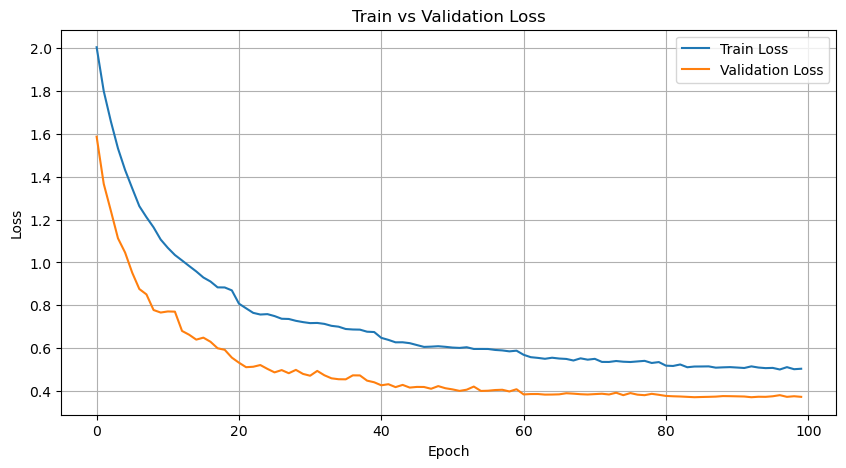

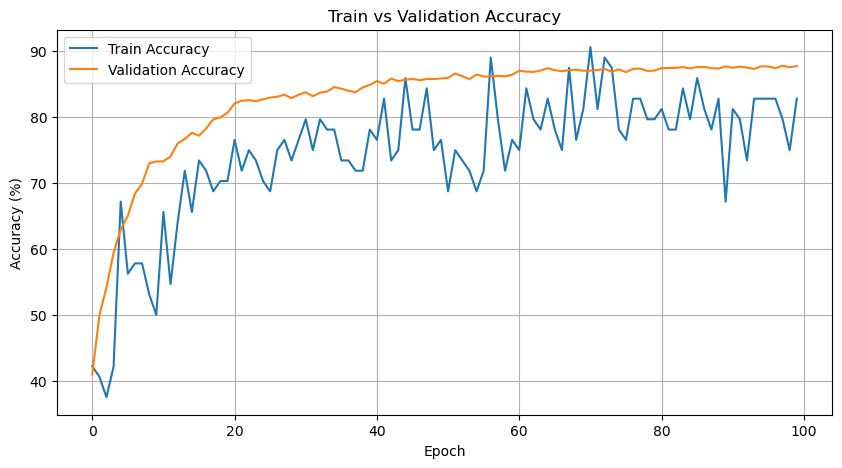

Training complete.
Model saved as cifar_mynet_final.pt
Loss and accuracy plots saved as loss_fig.png and accuracy_fig.png


In [15]:
main()

==> Preparing data..
Classification Report:
              precision    recall  f1-score   support

    airplane       0.88      0.90      0.89      1000
  automobile       0.95      0.93      0.94      1000
        bird       0.84      0.79      0.81      1000
         cat       0.74      0.73      0.74      1000
        deer       0.84      0.89      0.86      1000
         dog       0.79      0.80      0.80      1000
        frog       0.89      0.92      0.90      1000
       horse       0.92      0.90      0.91      1000
        ship       0.93      0.93      0.93      1000
       truck       0.93      0.93      0.93      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



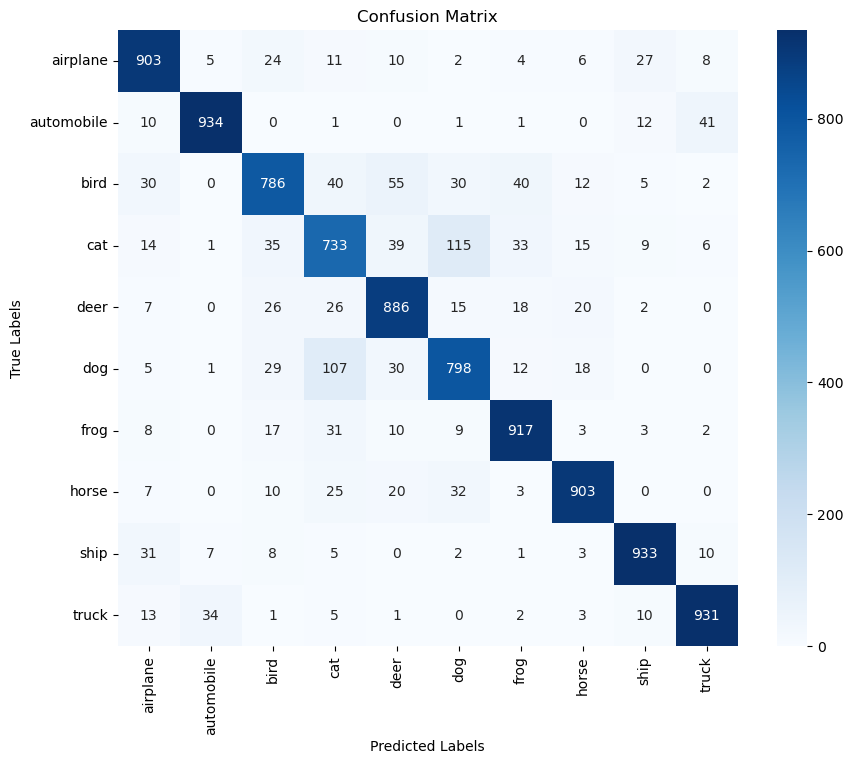

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load the saved model
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = MyNet().to(device)
model.load_state_dict(torch.load("cifar_mynet_final.pt", map_location=device))
model.eval()

# Prepare test data
_, _, test_loader = data_download_and_preprocess(batch_size=100, validation_size=0.2)

# Collect predictions and true labels
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Generate classification report
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=test_loader.dataset.classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()